# Single Cell Python Thresholds

Setting empirical thresholds for positivity, defining populations. Some simple statistical analyses. Visualization of tSNE and gene expression data and graphing performed in a seperate R notebook using the package Seurat.

Some simple subtractions done, presuming that variation in UMI capture is strictly a function of efficiency, and that efficiency in the canine spike-in population is equivalent to that of the human population. This should broadly be true, after subtracting doublets.



In [1]:
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import sys
scripts = 'Scripts'
import importlib
sys.path.append(scripts)
import SingleCellPython
import numpy as np
dataFolder = 'Sequencing/NS_meOH/outs/'
sns.set_style("white")
sns.set_style("ticks")
import scipy
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB2','PB1','PA',  'HA','NP','NA','M_mRNA','NS_mRNA']
fluColors = {}
alternateFlu = ['PB2_mRNA','PB1_mRNA','PA_mRNA',  'HA_mRNA','NP_mRNA','NA_mRNA','M_mRNA','NS_vRNA']
otherfluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
for color, segment in enumerate(alternateFlu):
    otherfluColors[segment] = colors[color]
typeI = ['IFNB1', 'IFNA1', 'IFNA2', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8','IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17' ]
typeIII = ['IL28A', 'IL28B', 'IL29']
#Threshold of positivity, likely would act similar to an FDR
quantileThresh = 0.99
from statsmodels.stats import multitest
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
from scipy.stats import poisson

load in raw matrices of canine and human, then subset to accepted barcodes


In [2]:
canineRaw = dataFolder + 'raw_gene_bc_matrices/canine/'
humanFluRaw = dataFolder + 'raw_gene_bc_matrices/human_flu/'
processedHumanBarcodes = dataFolder + 'filtered_gene_bc_matrices/human_flu/barcodes.tsv'
processedCanineBarcodes = dataFolder + 'filtered_gene_bc_matrices/canine/barcodes.tsv'

canineData = SingleCellPython.MatrixToPanda(canineRaw + 'barcodes.tsv', canineRaw + 'genes.tsv', canineRaw + 'matrix.mtx',
                                           False, False)
humanData = SingleCellPython.MatrixToPanda(humanFluRaw + 'barcodes.tsv', humanFluRaw + 'genes.tsv', humanFluRaw + 'matrix.mtx',
                                           False, False)

humanCells =  pd.read_csv(processedHumanBarcodes, names = ['cell'], sep='\t')
canineCells = pd.read_csv(processedCanineBarcodes, names = ['cell'], sep='\t')

acceptedCells = pd.concat([humanCells, canineCells])
                          
                          
acceptedCells = acceptedCells.drop_duplicates().reset_index(drop=True)
canineData['identity'] = 'canine'
humanData['identity'] = 'human'
canineData = canineData.merge(acceptedCells, on =['cell'])
humanData = humanData.merge(acceptedCells, on =['cell'])

combine human reads in canine barcodes.

In [3]:
combined = pd.concat([canineData, humanData])
combined = combined.groupby(['identity', 'cell']).UMI.sum().reset_index()
combined = combined.pivot(index = 'cell', columns = 'identity', values = 'UMI').fillna(0).reset_index()
combined['cell_identity'] = 'none'
combined.loc[combined.cell.isin(humanCells.cell),'cell_identity'] = 'human'
combined.loc[combined.cell.isin(canineCells.cell),'cell_identity'] = 'canine'
combined.loc[(combined.cell.isin(canineCells.cell)) & (combined.cell.isin(humanCells.cell)),'cell_identity'] = 'both'


Annotation by cellranger. Clearly flawed, as cells that are canine with high levels of human contamination are marked doublets, rather than canine. 

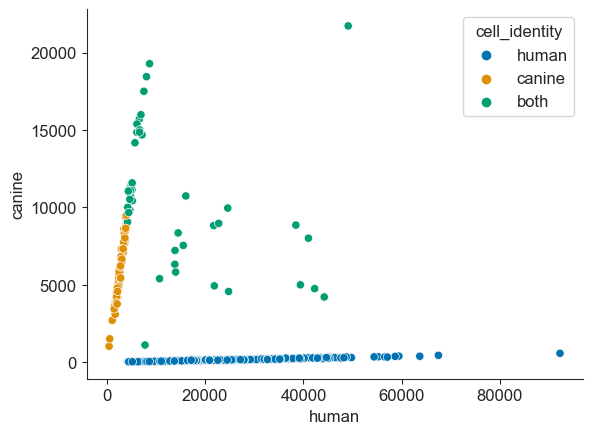

In [4]:
sns.scatterplot(data=combined, x="human", y="canine", hue = 'cell_identity', palette=colors[:3])
sns.despine()
plt.savefig('Figures/original10xcellAnnotation.pdf', format='pdf', bbox_inches = "tight")

look at fraction of human reads in canine, and vice-versa. There should be some distribution followed by true doublets. Set a threshold based on the shape of this distribution.

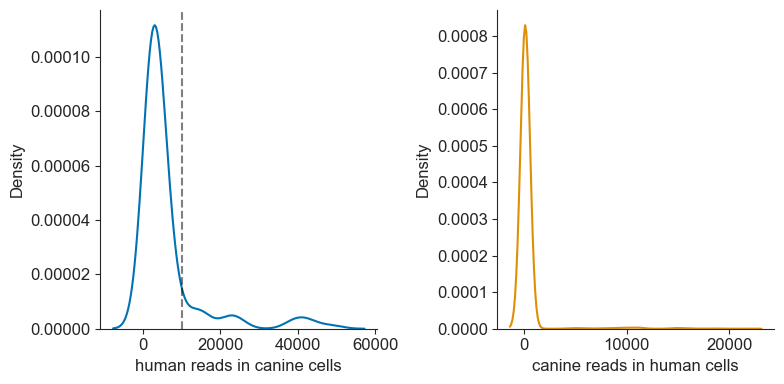

In [5]:
figure, axes = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(combined[combined.cell_identity != 'human'].human, bw_method=0.3, ax= axes[0], color=colors[0])
axes[0].set_xlabel('human reads in canine cells')
axes[0].axvline(x=10000,color = 'k',ls = '--', alpha =0.5)
sns.kdeplot(combined[combined.cell_identity != 'canine'].canine, bw_method=0.3, ax= axes[1], color=colors[1])
axes[1].set_xlabel('canine reads in human cells')
sns.despine()

figure.tight_layout()
plt.savefig('Figures/originalUMIdistributionAnnotation.pdf', format='pdf', bbox_inches = "tight")

Fix doublet annotation, and go ahead and remove low UMI human that are consistent with contamination). Will likely set an even higher threshold before I am done, but just for now.

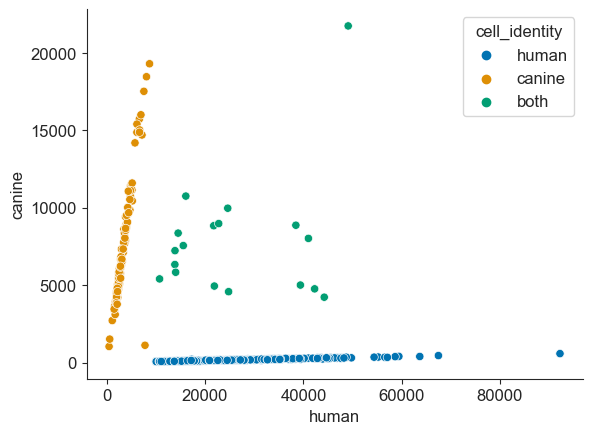

In [6]:
combined = combined[(combined.cell_identity == 'canine') | (combined.cell_identity == 'both') | (combined.human >= 10000)]
combined.loc[(combined.cell_identity == 'both') & (combined.human < 10000), 'cell_identity'] = 'canine'
sns.scatterplot(data=combined, x="human", y="canine", hue = 'cell_identity', palette=colors[:3])
sns.despine()
plt.savefig('Figures/fixed10xcellAnnotation.pdf', format='pdf', bbox_inches = "tight")

Lets start with doublet frequency. Use the method described in Bloom (2018, DOI 10.1101/293639).

In [7]:
doubles = len(combined[combined.cell_identity == 'both'])
human = len(combined[combined.cell_identity == 'human']) + doubles
canine = len(combined[combined.cell_identity == 'canine']) + doubles

#calculate total number of droplets
numDrop = (canine + doubles) * (human + doubles)/doubles
#µ1
µ1 = -np.log((numDrop - human -doubles)/numDrop)
#µ2
µ2 = -np.log((numDrop - canine - doubles)/numDrop)

#frequency
multiFreq = 1 - (((µ1 + µ2) * 2.718 ** (-µ1 + µ2))/(1 - 2.718**(-µ1 - µ2)))
print("%s cells are human only" % human)
print("%s cells are canine only" % canine)
print("Then we may infer %s percent of emulsions are likely multiplets" % (round(multiFreq*100, 2)))


2124 cells are human only
136 cells are canine only
Then we may infer 4.89 percent of emulsions are likely multiplets


Lets remove high UMI human as potential doublets. This removes ~10% of the dataset, so might be a little stringent,but lines up with additional modalities that suggest doublets.

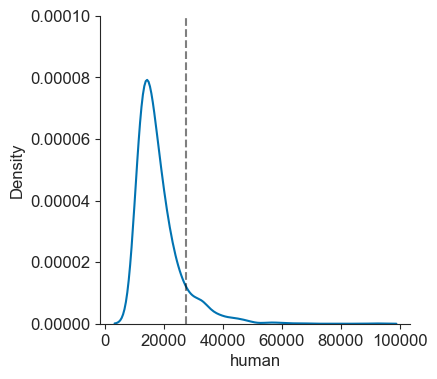

In [8]:
figure, ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(combined[combined.cell_identity != 'canine'].human, bw_method=0.3,  color=colors[0], ax=ax)
sns.despine()
ax.axvline(x=27500,color = 'k',ls = '--', alpha =0.5)
combined = combined[(combined.cell_identity == 'canine') | (combined.cell_identity == 'both') | (combined.human < 27500)]
a = plt.ylim(0,10**-4)
plt.savefig('Figures/doubletRemoval.pdf', format='pdf', bbox_inches = "tight")


Alright, now time to calculate some numbers. Using the canine cells as, effectively, a background estimate,as in Russell et al 2019 we assume poisson sampling. However, one slight difference is that we also correct for different levels of canine vs human transcripts. The best estimate is likely from the doublets, so use a frequency calculated from doublets. 


Long story long, calculate median contamination fraction for canine cells, then interpolate "expected" human reads from median doublet frequency. This should be the expected fraction from contamination alone.

Then, assuming poisson sampling, graph corrected p-values in prior work to see what a reasonable cutoff might be.

Do all IFN as well as type I and type III seperately. Justify below.

Use median to remove effects of outliers for influenza, however for interferons use mean as the mean as the median value is 0.

So first lets calculate expected fractions by Poisson alone.



In [9]:


prefix = 'human_flu_'
nonDoubletList = combined[combined.cell_identity=='canine'].cell
justCanineHuman = humanData.loc[humanData.cell.isin(nonDoubletList),]
fluGenes = [prefix + segment for segment in segments]
typeIgenes = [prefix + gene for gene in typeI]
typeIIIgenes = [prefix + gene for gene in typeIII]

genesOfInterest = fluGenes + typeIgenes + typeIIIgenes
justCanineHuman = justCanineHuman.loc[justCanineHuman.gene.isin(genesOfInterest),]
canineRatio = np.median(combined[combined.cell_identity == 'both'].human/combined[combined.cell_identity == 'both'].canine)

typeIFrame = justCanineHuman[justCanineHuman.gene.isin(typeIgenes)].groupby(['cell']).sum().reset_index()
typeIIIFrame = justCanineHuman[justCanineHuman.gene.isin(typeIIIgenes)].groupby(['cell']).sum().reset_index()
IFNFrame = pd.concat([typeIFrame, typeIIIFrame]).groupby(['cell']).sum().reset_index()
fluFrame = justCanineHuman[justCanineHuman.gene.isin(fluGenes)].groupby(['cell']).sum().reset_index()

totalUMIcanine = combined[combined.cell_identity == 'canine']

typeIFrame = totalUMIcanine.merge(typeIFrame, on='cell', how='left').fillna(0)
typeIFrame['fraction'] = typeIFrame.UMI/typeIFrame.canine
typeIthresh = np.mean(typeIFrame.fraction)/canineRatio

typeIIIFrame = totalUMIcanine.merge(typeIIIFrame, on='cell', how='left').fillna(0)
typeIIIFrame['fraction'] = typeIIIFrame.UMI/typeIIIFrame.canine
typeIIIthresh = np.mean(typeIIIFrame.fraction)/canineRatio


#will need to also do each flu gene individually, but lets do that next
fluFrame = totalUMIcanine.merge(fluFrame, on='cell', how='left').fillna(0)
fluFrame['fraction'] = fluFrame.UMI/fluFrame.canine
fluThresh = np.median(fluFrame.fraction)/canineRatio



Now calculate similar numbers for each individual flu segment.

In [10]:
thresholds = {}
for gene in segments:
    flugene = prefix + gene
    relevantFrame = justCanineHuman[justCanineHuman.gene == flugene].groupby(['cell']).sum().reset_index()
    relevantFrame = totalUMIcanine.merge(relevantFrame, on='cell', how='left').fillna(0)
    relevantFrame['fraction'] = relevantFrame.UMI/relevantFrame.canine
    thresholds[gene] = np.median(relevantFrame.fraction)/canineRatio

    



Calculate p values assuming a poisson distribution, then provide q values with FDR_BH. 

In [11]:
nonDoubletList = combined[combined.cell_identity=='human'].cell
justHuman = humanData.loc[humanData.cell.isin(nonDoubletList),]
finalData = combined[combined.cell_identity == 'human'].copy()

#get fractions

typeI = justHuman[justHuman.gene.isin(typeIgenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'type_I_IFN'} )
finalData = finalData.merge(typeI, on='cell', how='left').fillna(0)
finalData['type_I_IFN'] = finalData.type_I_IFN / finalData.human
finalData['type_I_IFN_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.type_I_IFN * row.human , mu=typeIthresh * row.human), axis=1)
finalData['type_I_IFN_qval'] = np.log10(multitest.multipletests(finalData.type_I_IFN_pval, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)[1])
#replace -inf values with minimum observed
finalData.loc[finalData.type_I_IFN_qval == -np.inf,'type_I_IFN_qval'] = finalData[finalData.type_I_IFN_qval != -np.inf].type_I_IFN_qval.min()



typeIII = justHuman[justHuman.gene.isin(typeIIIgenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'type_III_IFN'} )
finalData = finalData.merge(typeIII, on='cell', how='left').fillna(0)
finalData['type_III_IFN'] = finalData.type_III_IFN / finalData.human
#poisson but calculate vs anticipated UMI
finalData['type_III_IFN_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.type_III_IFN * row.human, mu=typeIIIthresh * row.human), axis=1)
finalData['type_III_IFN_qval'] = np.log10(multitest.multipletests(finalData.type_III_IFN_pval, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)[1])
#replace -inf values with minimum observed
finalData.loc[finalData.type_III_IFN_qval == -np.inf,'type_III_IFN_qval'] = finalData[finalData.type_III_IFN_qval != -np.inf].type_III_IFN_qval.min()


flu = justHuman[justHuman.gene.isin(fluGenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'influenza'} )
finalData = finalData.merge(flu, on='cell', how='left').fillna(0)
finalData['influenza'] = finalData.influenza / finalData.human
finalData['influenza_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.influenza * row.human, mu=fluThresh * row.human), axis=1)
finalData['influenza_qval'] = np.log10(multitest.multipletests(finalData.influenza_pval, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)[1])
#replace -inf values with minimum observed
finalData.loc[finalData.influenza_qval == -np.inf,'influenza_qval'] = finalData[finalData.influenza_qval != -np.inf].influenza_qval.min()



/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


Plot survivorship curve to set an ad hoc FDR based on inflection points.

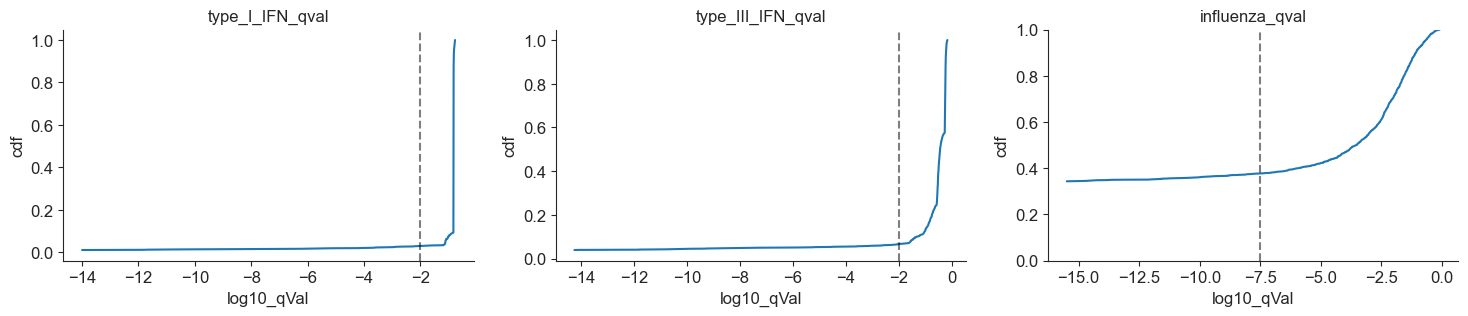

In [12]:
def cdf(dataframe, column):
    #modified from https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
    cdfFrame = pd.DataFrame(dataframe.groupby(column).count()).rename(columns={'cell':'frequency'})
    cdfFrame['pdf'] = cdfFrame['frequency'] / sum(cdfFrame['frequency'])
    cdfFrame['cdf'] = cdfFrame['pdf'].cumsum()
    return cdfFrame.reset_index()[[column, 'cdf']]






fig, axes = plt.subplots(1,3,figsize=(18,3))
order = ['type_I_IFN_qval','type_III_IFN_qval', 'influenza_qval']
adHoc = [-2, -2, -7.5]
for axis, element in enumerate(order):
    ax = axes[axis]
    graph = cdf(finalData, element)
    sns.lineplot(data = graph, x = element, y='cdf', ax= ax)
    ax.axvline(x=adHoc[axis],color = 'k',ls = '--', alpha =0.5)
    plt.ylim(0,1)
    sns.despine()
    ax.set_xlabel('log10_qVal')
    ax.set_title(element)
    finalData[element[:-5] + '_positive'] = finalData[element] < adHoc[axis]
plt.savefig('Figures/qvalIFNFlu.pdf', format='pdf', bbox_inches = "tight")



In [13]:

#write list of accepted cells for Seurat
finalData.cell.to_csv('Results/acceptedCells.csv')
finalData[finalData.influenza_positive].cell.to_csv( 'Results/Flu_list.csv')

calculate pvals, not qvals, to be a little less stringent on segments

In [14]:
for gene in segments:
    geneFrame = justHuman[justHuman.gene == prefix + gene].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':gene} )
    finalData = finalData.merge(geneFrame, on='cell', how='left').fillna(0)
    finalData[gene] = finalData[gene] / finalData.human

    

/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alistair/anaconda3/lib/python3.7/site-packages/p

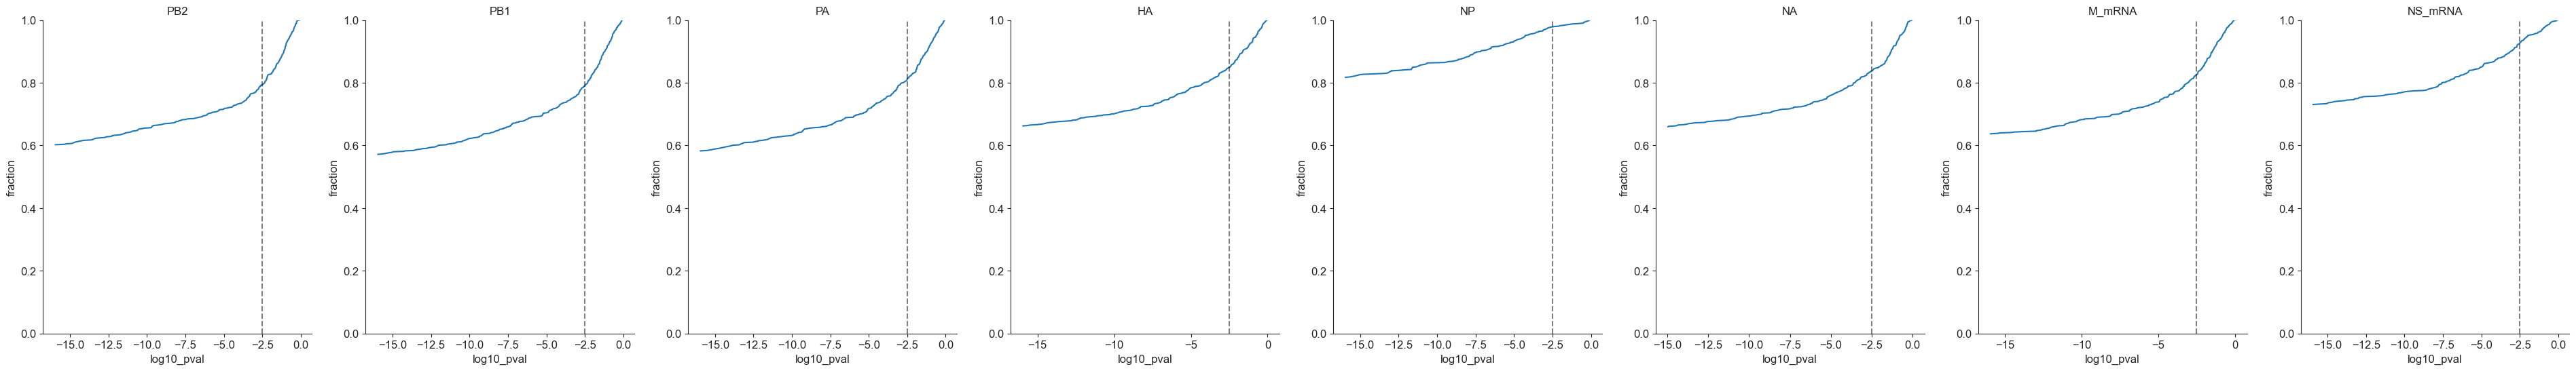

In [15]:
fig, axes = plt.subplots(1,8,figsize=(48,6))
adHoc = [-2.5, -2.5, -2.5,-2.5, -2.5, -2.5,-2.5,-2.5]
for axis, gene in enumerate(segments):
    ax = axes[axis]
    finalData[gene + '_pval'] = np.log10(finalData.apply(lambda row: 1- poisson.cdf(k=row[gene] * row.human , mu=thresholds[gene] * row.human), axis=1))
    finalData.loc[finalData[gene+'_pval'] == -np.inf,gene+'_pval'] = finalData[finalData[gene+'_pval'] != -np.inf][gene+'_pval'].min()

    graph = cdf(finalData[finalData.influenza_positive], gene + '_pval')
    sns.lineplot(data = graph, x = gene + '_pval', y='cdf', ax= ax)
    ax.set_ylim(0,1)
    sns.despine()
    ax.set_ylabel('fraction')
    ax.set_title(gene)
    ax.set_xlabel('log10_pval')
    ax.axvline(x=adHoc[axis],color = 'k',ls = '--', alpha =0.5)
    finalData[gene + '_positive'] = finalData[gene + '_pval'] < adHoc[axis]
plt.savefig('Figures/pvalSegment.pdf', format='pdf', bbox_inches = "tight")


Check distribution of total gene numbers in final frame to ensure reasonable distribution.

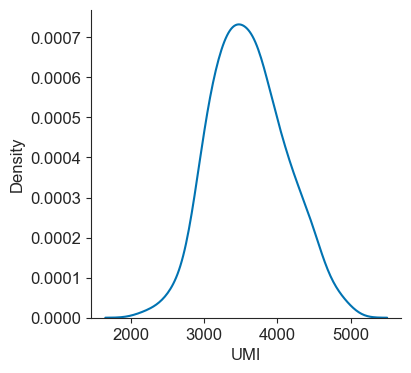

In [16]:
figure, ax = plt.subplots(1,1, figsize=(4,4))

graph = humanData[(humanData.cell.isin(finalData.cell)) & (humanData.UMI > 0)].groupby(['cell']).count()
sns.kdeplot(graph.UMI, bw_method=0.3,  color=colors[0])
sns.despine()
plt.savefig('Figures/geneCountsNSmut.pdf', format='pdf', bbox_inches = "tight")

Show how distributions match thresholds, I think worth pointing out in terms of excluding contamination. Set dotted line at maximum value excluded. Graph kernel density estimates.

For interferons, specifically, it would aid in analysis if we could consider type I and type III positivity as a single value. If this is fair to do, we would expect that, statistically, type I positive are more likely to be type III positive, and vice-versa. Is this the case?

The null hypothesis is rejected at a pvalue of 3.1640637735882904e-58


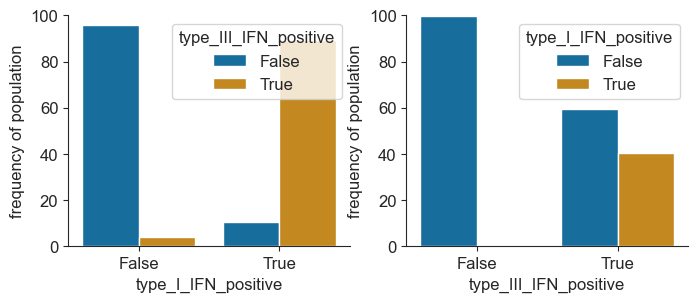

In [17]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(finalData.type_I_IFN_positive, finalData.type_III_IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(finalData.type_I_IFN_positive, finalData.type_III_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_I_IFN_positive', y='value', hue='type_III_IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylabel('frequency of population')

axes[0].set_ylim(0,100)
frequency = pd.crosstab(finalData.type_III_IFN_positive, finalData.type_I_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_III_IFN_positive', y='value', hue='type_I_IFN_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/typeIvsIII.pdf', format='pdf', bbox_inches = "tight")


Combine measurements into one boolean value for IFN positivity. Output for visualization on UMAP in Seurat.

In [18]:
finalData['IFN_positive'] = (finalData.type_III_IFN_positive) | (finalData.type_I_IFN_positive)
finalData[finalData.IFN_positive].cell.to_csv( 'Results/IFN_list.csv')


Some counts for context.

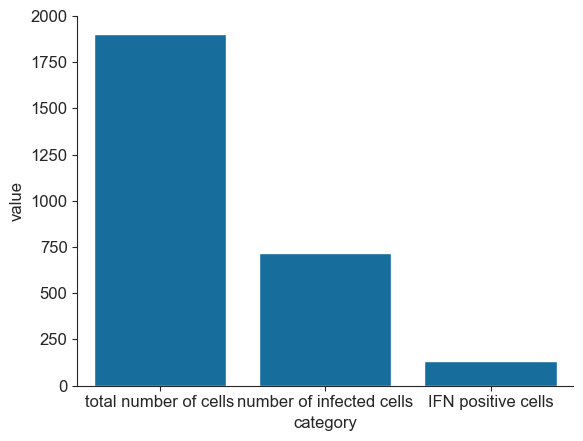

In [19]:
graph = pd.DataFrame({'category':['total number of cells', 'number of infected cells', 'IFN positive cells'], 
                      
                      
                      'value':[len(finalData), len(finalData[finalData.influenza_positive]), len(finalData[finalData.IFN_positive])]})
sns.barplot(data=graph, x='category', y='value', color=colors[0])
sns.despine()
plt.ylim(0,2000)
plt.savefig('Figures/counts.pdf', format='pdf', bbox_inches = "tight")

Influenza burden

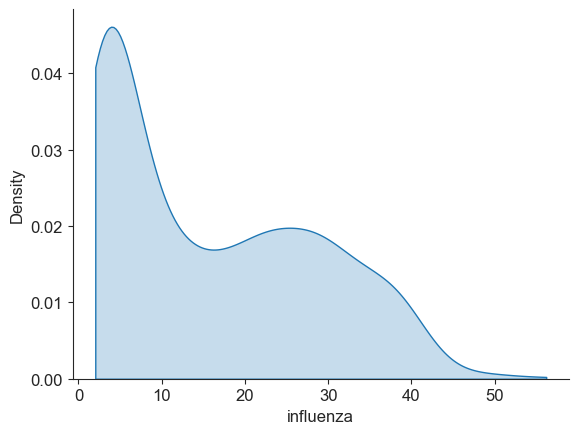

In [17]:
sns.kdeplot(finalData[finalData.influenza_positive].influenza * 100, cut=0, fill=True)
sns.despine()
plt.savefig('Figures/fluBurdenPosCells.pdf', format='pdf', bbox_inches = "tight")

Frequencies of flu segments relative to one-another. Altered relative to accepted values with wild-type.

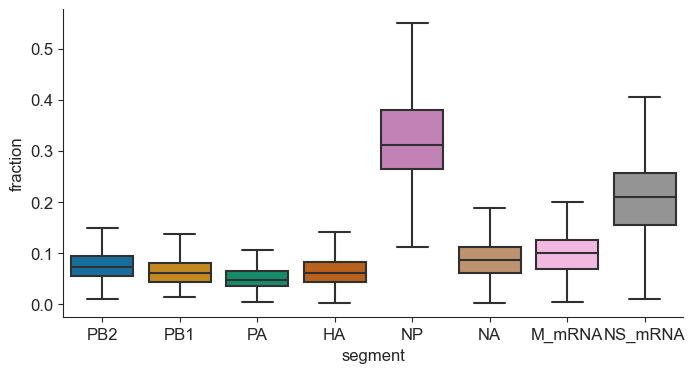

In [18]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
 
graph = finalData[finalData.influenza_positive][segments].copy()
graph['sum'] = graph.sum(axis=1)
for segment in segments:
    graph[segment] = graph[segment]/graph['sum']
graph = graph[segments].stack().reset_index().rename(columns = {'level_1':'segment', 0:'fraction'})
sns.boxplot(data = graph, x= 'segment', y ='fraction', order = segments, palette = fluColors,  ax = ax, showfliers = False,)
sns.despine()
plt.savefig('Figures/fracNS1mut.pdf', format='pdf', bbox_inches = "tight")

Any change based on interferon?

Segments with significance with an FDR of 0.1
NP NA M_mRNA


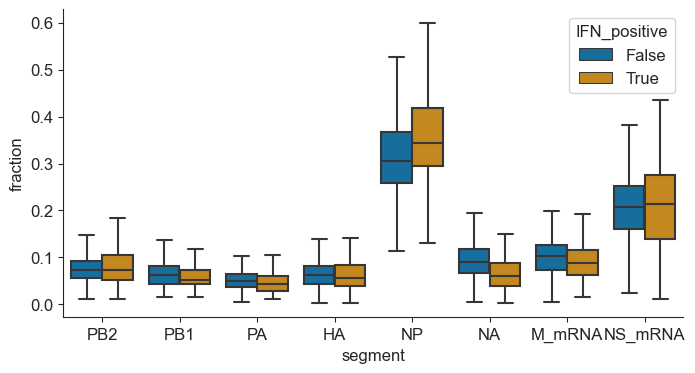

In [22]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
 
graph = finalData[finalData.influenza_positive][segments + ['IFN_positive']].copy()
graph['sum'] = graph[segments].sum(axis=1)
for segment in segments:
    graph[segment] = graph[segment]/graph['sum']
graph = pd.melt(graph, id_vars=['IFN_positive'], value_vars=segments).rename(columns={'value':'fraction', 'variable':'segment'})
sns.boxplot(data = graph, x= 'segment', y ='fraction', palette= colors[:2], order = segments, hue='IFN_positive',showfliers = False,  ax = ax)
sns.despine()
plt.savefig('Figures/fluRatiofluIFN.pdf', format='pdf', bbox_inches = "tight")

pvals = []
for segment in segments:
    currFrame = graph[graph.segment == segment]
    statistic, pval = scipy.stats.ttest_ind(currFrame[currFrame.IFN_positive].fraction, currFrame[~(currFrame.IFN_positive)].fraction, equal_var=False, )
    pvals += [pval]
pvals  = multitest.multipletests(pvals, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
print('Segments with significance with an FDR of 0.1')
print(' '.join([segment for index,segment in enumerate(segments) if pvals[index]]))
plt.savefig('Figures/fluFractionIFNpartition.pdf', format='pdf', bbox_inches = "tight")

Previous descriptions of paracrine induction of interferon. Do we, broadly, see interferon and influenza co-occur?

The null hypothesis is rejected at a pvalue of 4.497852227241623e-47


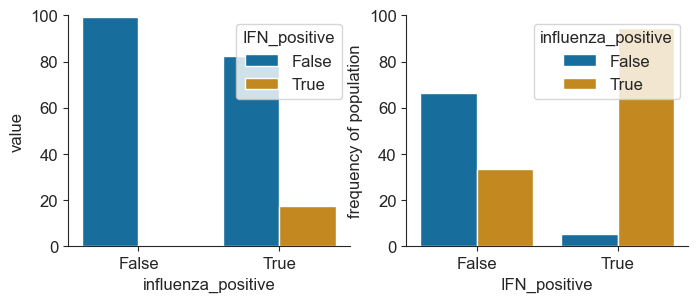

In [23]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(finalData.influenza_positive, finalData.IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
contingency = contingency.stack().reset_index().rename(columns={0:'value'})

frequency = pd.crosstab(finalData.influenza_positive, finalData.IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'influenza_positive', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylim(0,100)

frequency = pd.crosstab(finalData.IFN_positive, finalData.influenza_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='influenza_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/IFNvsFlu.pdf', format='pdf', bbox_inches = "tight")



Yes, we do. The majority of IFN+ cells are infected. Indeed, given our stringent trhesholds, it is possible the rare, flu- IFN+ cells are still infected, just not meeting our threshold. Moreover, the interferon positivity is roughly in line with prior estimates, indeed, perhaps slightly higher but this could be due to better sampling of high flu cells as described below.

is there a relationship between the amount of influenza and interferon induction? Subset on influenza+ cells and test if populations are significantly different.

The null hypothesis is rejected at a pvalue of 8.829951105667096e-25


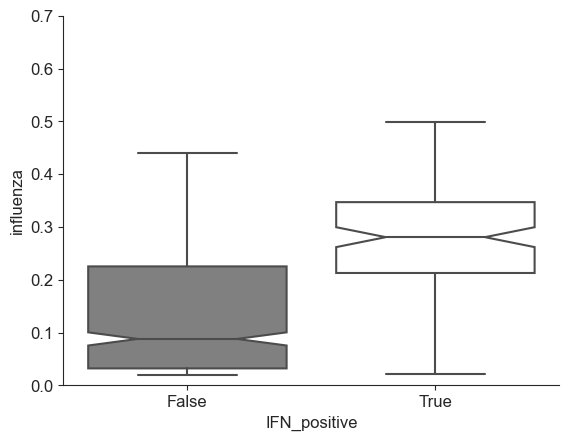

In [24]:
graph = finalData[finalData.influenza_positive]
statistic, pval = scipy.stats.ttest_ind(graph[graph.IFN_positive].influenza, graph[~(graph.IFN_positive)].influenza, equal_var=False)
#sns.violinplot(x="IFN_positive", y="influenza", data=graph, order=[False, True], cut=0)
sns.boxplot(x="IFN_positive", y="influenza", data=graph, order=[False, True], notch=True, palette = ['0.5','1'], showfliers=False)

plt.ylim(0,0.7)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
plt.savefig('Figures/IFNvsfluBurden.pdf', format='pdf', bbox_inches = "tight")





What about presence/absence of each segment? Generate contingency tables but just show fraction absent for graph. perform multiple hypothesis correction on pvals.

Segments with significance with an FDR of 0.05
PB2 PB1 PA HA NA M_mRNA


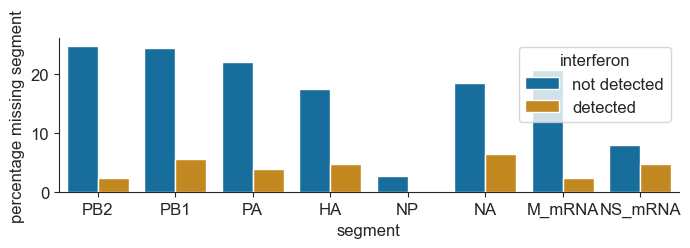

In [25]:
graph = []
pvals = []
fig,ax = plt.subplots(figsize=(8,2))

for segment in segments:
    contingency = pd.crosstab(finalData[finalData.influenza_positive][segment + '_positive'], finalData[finalData.influenza_positive].IFN_positive)
    ratio, pval = scipy.stats.fisher_exact(contingency)
    contingency = contingency.stack().reset_index().rename(columns={0:'value'})
    #graph absence
    IFNpos = float(contingency[(contingency.IFN_positive) & ~(contingency[segment + '_positive'])].value/contingency[(contingency.IFN_positive)].value.sum()*100)
    IFNneg = float(contingency[~(contingency.IFN_positive) & ~(contingency[segment + '_positive'])].value/contingency[~(contingency.IFN_positive)].value.sum()*100)
    graph+= [pd.DataFrame({'segment':[segment, segment], 'interferon':['not detected','detected'], 'percentage missing segment':[IFNneg, IFNpos]})]
    pvals += [pval]
graph = pd.concat(graph)
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

sns.barplot(x= 'segment', y='percentage missing segment', hue='interferon', palette = colors[:2],data=graph, ax =ax)
sns.despine()
print('Segments with significance with an FDR of 0.05')
print(' '.join([segment for index,segment in enumerate(segments) if pvals[index]]))
plt.savefig('Figures/missingsegments.pdf', format='pdf', bbox_inches = "tight")


Higher fraction is associated with more coinfection, what if we limit to only high expressers? 


Segments with significance with an FDR of 0.05



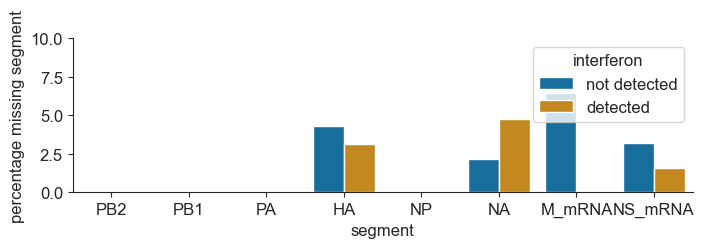

In [26]:


meanVal = finalData[(finalData.IFN_positive) & (finalData.influenza_positive)].influenza.median()
graph = []
pvals = []
fig,ax = plt.subplots(figsize=(8,2))
polSegments = ['PB2', 'PB1', 'PA', 'NP']

for segment in polSegments:
    currFrame =finalData[finalData.influenza >= meanVal ].groupby(['IFN_positive'])[segment + '_positive'].mean().reset_index()
    currFrame['segment'] = segment
    currFrame['percentage missing segment'] = (1 - currFrame[segment + '_positive']) * 100
    graph += [currFrame[['segment','percentage missing segment', 'IFN_positive']]]
    
nonPolSegments = ['HA','NA','M_mRNA', 'NS_mRNA']
for segment in nonPolSegments:
    contingency = pd.crosstab(finalData[finalData.influenza >= meanVal ][segment + '_positive'], finalData[finalData.influenza >= meanVal].IFN_positive)
    ratio, pval = scipy.stats.fisher_exact(contingency)
    contingency = contingency.stack().reset_index().rename(columns={0:'value'})
    #graph absence
    IFNpos = float(contingency[(contingency.IFN_positive) & ~(contingency[segment + '_positive'])].value/contingency[(contingency.IFN_positive)].value.sum()*100)
    IFNneg = float(contingency[~(contingency.IFN_positive) & ~(contingency[segment + '_positive'])].value/contingency[~(contingency.IFN_positive)].value.sum()*100)
    graph+= [pd.DataFrame({'segment':[segment, segment], 'interferon':['not detected','detected'], 'percentage missing segment':[IFNneg, IFNpos]})]
    pvals += [pval]
graph = pd.concat(graph)
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

sns.barplot(x= 'segment', y='percentage missing segment', hue='interferon', order= segments, palette = colors[:2],data=graph, ax =ax)
sns.despine()
plt.ylim(0,10)
print('Segments with significance with an FDR of 0.05')
print(' '.join([segment for index,segment in enumerate(nonPolSegments) if pvals[index]]))
plt.savefig('Figures/missingsegmentsCutoff.pdf', format='pdf', bbox_inches = "tight")



For NS specifically, subsetting on high flu infections, what is the distribution of NS expression relative to the other segments? Assuming greater-than, use one-tailed t-test comparison.

What about deletions? Annotated in a seperate, companion notebook, but graphed here.

In [40]:
#read in deletions, subset to accepted cells
deletions = pd.read_csv('Results/curatedDeletions.tsv', sep='\t')[['barcode', 'segment', 'fiveprime', 'threeprime', 'count', 'nonDeletionCounts']]
deletions = deletions.rename(columns = {'barcode':'cell'})
deletions = deletions[deletions.cell.isin(finalData.cell)]
#filter to only > 200nt to exclude small deletions
deletions['length'] = deletions.threeprime-deletions.fiveprime
deletions = deletions[deletions.length > 200]
finalData['deletion_observed'] = finalData.cell.isin(deletions.cell)

Filter for only deletions > 200nt

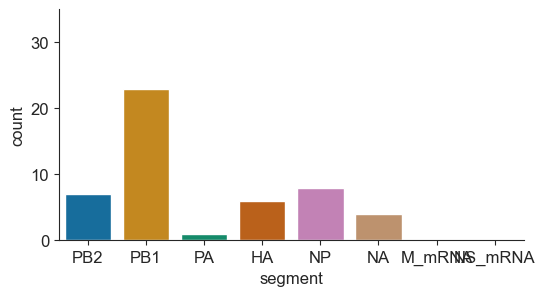

In [41]:
fig,ax = plt.subplots(figsize=(6,3))
graph = deletions.groupby(['segment']).count().reset_index()
sns.barplot(data=graph, x= 'segment', y='count', palette = otherfluColors, order= alternateFlu, ax =ax)
plt.ylim(0,35)
sns.despine()
a = ax.set_xticklabels(segments)
plt.savefig('Figures/numDeletionsObserved.pdf', format='pdf', bbox_inches = "tight")


Number of infections in which deletions were observed. (6.8%)

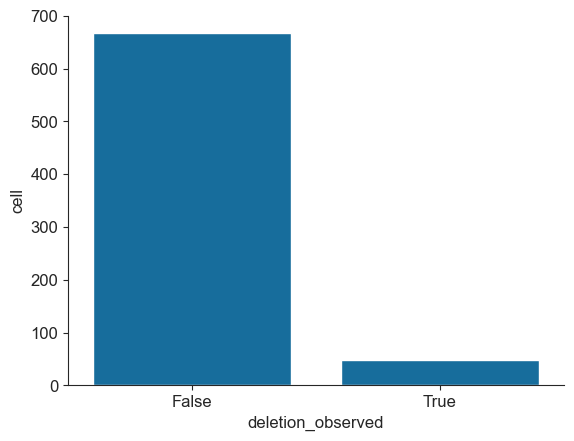

In [42]:
sns.barplot(data =finalData[finalData.influenza_positive].groupby(['deletion_observed']).count().reset_index(), x = 'deletion_observed', y='cell', color=colors[0])
sns.despine()
plt.ylim(0,700)
plt.savefig('Figures/numInfectionsDeletionsObserved.pdf', format='pdf', bbox_inches = "tight")


Do deletions, broadly, associate with interferon?

The null hypothesis is rejected at a pvalue of 0.0026878969710210144


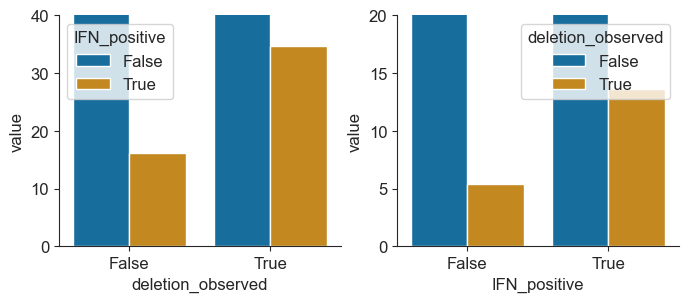

In [43]:
contingency = pd.crosstab(finalData[finalData.influenza_positive].deletion_observed, finalData[finalData.influenza_positive].IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
fig,axes = plt.subplots(1,2, figsize=(8,3))

frequency = pd.crosstab(finalData[finalData.influenza_positive].deletion_observed, finalData[finalData.influenza_positive].IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'deletion_observed', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylim(0,40)

frequency = pd.crosstab(finalData[finalData.influenza_positive].IFN_positive, finalData[finalData.influenza_positive].deletion_observed, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='deletion_observed', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,20)


if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
    
plt.savefig('Figures/deletionvsIFN.pdf', format='pdf', bbox_inches = "tight")


Is this simply as infections with higher flu fraction are better sampled for deletions?

The null hypothesis is rejected at a pvalue of 0.00020362778505976387


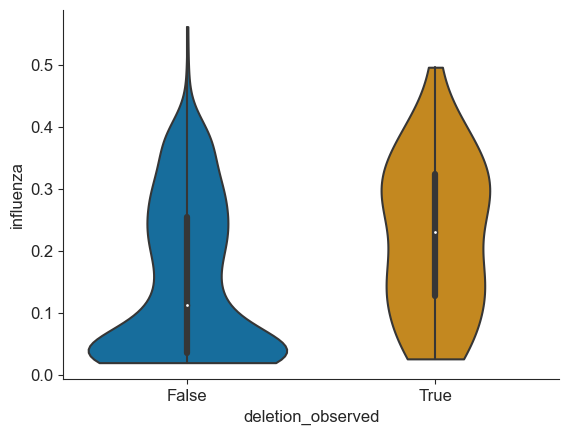

In [44]:
graph = finalData[finalData.influenza_positive]

statistic, pval = scipy.stats.ttest_ind(graph[graph.deletion_observed].influenza, graph[~(graph.deletion_observed)].influenza, equal_var=False)
sns.violinplot(data = graph, x="deletion_observed", y='influenza', common_norm=False, fill=True, hue_order = [False, True], cut=0,palette = colors[0:2])
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
sns.despine()
plt.savefig('Figures/deletionvsFluBurden.pdf', format='pdf', bbox_inches = "tight")


Look using similar cutoff to above, whether in higher flu infections, this still holds

the null hypothesis fails to be rejected at a pvalue of 0.26659898226838086


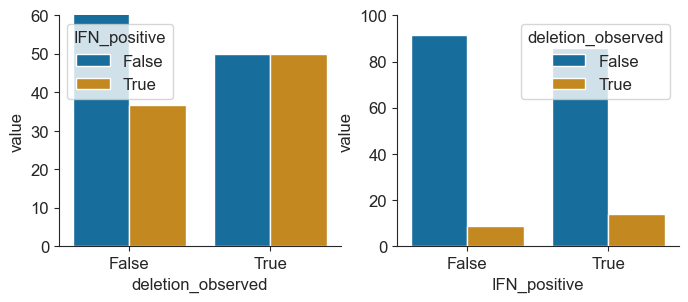

In [45]:
meanVal = finalData[(finalData.influenza_positive) & (finalData.deletion_observed)].influenza.median()

contingency = pd.crosstab(finalData[finalData.influenza > meanVal].IFN_positive, finalData[finalData.influenza > meanVal].deletion_observed)
ratio, pval = scipy.stats.fisher_exact(contingency)
fig,axes = plt.subplots(1,2, figsize=(8,3))

frequency = pd.crosstab(finalData[finalData.influenza > meanVal].deletion_observed, finalData[finalData.influenza > meanVal].IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'deletion_observed', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylim(0,60)

frequency = pd.crosstab(finalData[finalData.influenza > meanVal].IFN_positive, finalData[finalData.influenza > meanVal].deletion_observed, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='deletion_observed', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)


if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
    
plt.savefig('Figures/deletionvsIFNcutoff.pdf', format='pdf', bbox_inches = "tight")

Was this correction ok? In other words are these populations now reasonably comparable?

the null hypothesis fails to be rejected at a pvalue of 0.25454154579195615


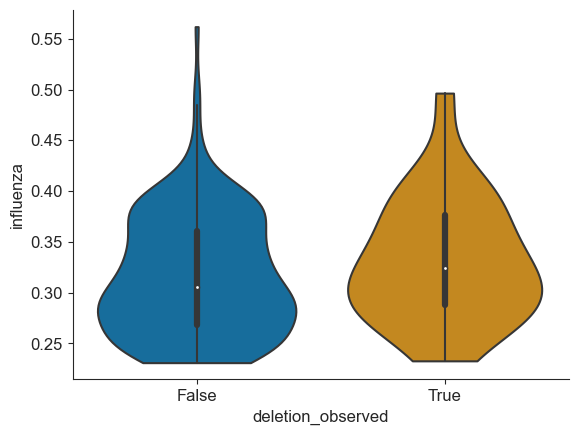

In [46]:
graph = finalData[finalData.influenza > meanVal]

statistic, pval = scipy.stats.ttest_ind(graph[graph.deletion_observed].influenza, graph[~(graph.deletion_observed)].influenza, equal_var=False)
sns.violinplot(data = graph, x="deletion_observed", y='influenza', common_norm=False, fill=True, hue_order = [False, True], cut=0,palette = colors[0:2])
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
sns.despine()
plt.savefig('Figures/deletionvsFluBurdenCorrected.pdf', format='pdf', bbox_inches = "tight")

Hmm, but why are deletions not reducing influenza fraction? Are they de novo/in coinfections? check if there are reads that support full-length, at least as many required to meet threshold for positivity in the first place.

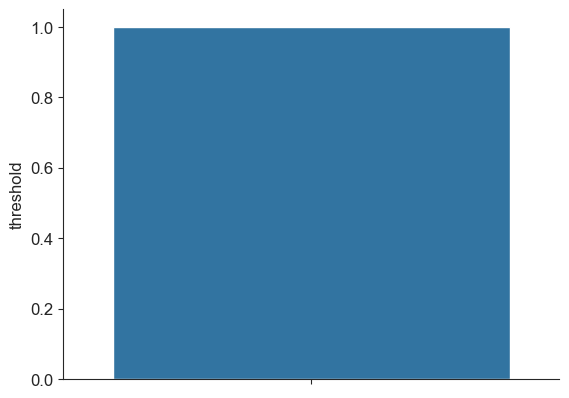

In [47]:
editedThresh = {}
for segment in thresholds:
    editedThresh[segment + '_mRNA'] = thresholds[segment]
deletions = deletions[deletions.cell.isin(finalData[finalData.influenza_positive].cell)]
deletions['threshold'] = deletions.apply(lambda row: row.nonDeletionCounts > editedThresh[row.segment], axis = 1)
sns.barplot(data = deletions, y ="threshold", orient="v" )
sns.despine()
plt.savefig('Figures/coinfDeletion.pdf', format='pdf', bbox_inches = "tight")


All deletions are likely coinfections or de novo.

# WT dataset

Wild-type dataset generated contemporaneously for some quick comparisons. Use NS1 thresholds to ensure comparing apples to apples.

In [28]:
dataFolder = 'Sequencing/WT_meOH/outs/'


In [29]:
canineRaw = dataFolder + 'raw_gene_bc_matrices/canine/'
humanFluRaw = dataFolder + 'raw_gene_bc_matrices/human_flu/'
processedHumanBarcodes = dataFolder + 'filtered_gene_bc_matrices/human_flu/barcodes.tsv'
processedCanineBarcodes = dataFolder + 'filtered_gene_bc_matrices/canine/barcodes.tsv'

canineData = SingleCellPython.MatrixToPanda(canineRaw + 'barcodes.tsv', canineRaw + 'genes.tsv', canineRaw + 'matrix.mtx',
                                           False, False)
humanData = SingleCellPython.MatrixToPanda(humanFluRaw + 'barcodes.tsv', humanFluRaw + 'genes.tsv', humanFluRaw + 'matrix.mtx',
                                           False, False)

humanCells =  pd.read_csv(processedHumanBarcodes, names = ['cell'], sep='\t')
canineCells = pd.read_csv(processedCanineBarcodes, names = ['cell'], sep='\t')

acceptedCells = pd.concat([humanCells, canineCells])
                          
                          
acceptedCells = acceptedCells.drop_duplicates().reset_index(drop=True)
canineData['identity'] = 'canine'
humanData['identity'] = 'human'
canineData = canineData.merge(acceptedCells, on =['cell'])
humanData = humanData.merge(acceptedCells, on =['cell'])

In [30]:
combined = pd.concat([canineData, humanData])
combined = combined.groupby(['identity', 'cell']).UMI.sum().reset_index()
combined = combined.pivot(index = 'cell', columns = 'identity', values = 'UMI').fillna(0).reset_index()
combined['cell_identity'] = 'none'
combined.loc[combined.cell.isin(humanCells.cell),'cell_identity'] = 'human'
combined.loc[combined.cell.isin(canineCells.cell),'cell_identity'] = 'canine'
combined.loc[(combined.cell.isin(canineCells.cell)) & (combined.cell.isin(humanCells.cell)),'cell_identity'] = 'both'

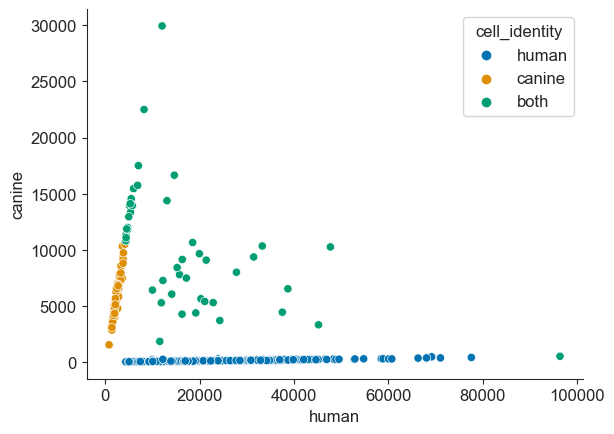

In [31]:
sns.scatterplot(data=combined, x="human", y="canine", hue = 'cell_identity', palette=colors[:3])
sns.despine()
plt.savefig('Figures/original10xcellAnnotationWT.pdf', format='pdf', bbox_inches = "tight")

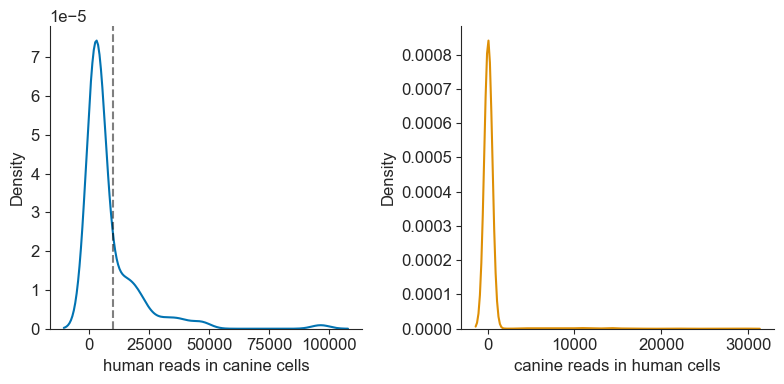

In [32]:
figure, axes = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(combined[combined.cell_identity != 'human'].human, bw_method=0.3, ax= axes[0], color=colors[0])
axes[0].set_xlabel('human reads in canine cells')
axes[0].axvline(x=10000,color = 'k',ls = '--', alpha =0.5)
sns.kdeplot(combined[combined.cell_identity != 'canine'].canine, bw_method=0.3, ax= axes[1], color=colors[1])
axes[1].set_xlabel('canine reads in human cells')
sns.despine()

figure.tight_layout()
plt.savefig('Figures/originalUMIdistributionAnnotationWT.pdf', format='pdf', bbox_inches = "tight")

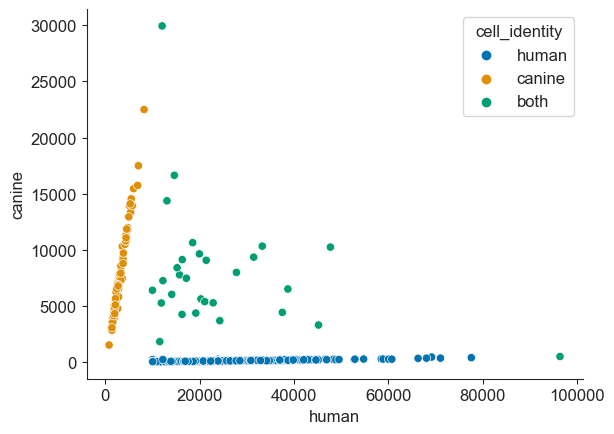

In [33]:
combined = combined[(combined.cell_identity == 'canine') | (combined.cell_identity == 'both') | (combined.human >= 10000)]
combined.loc[(combined.cell_identity == 'both') & (combined.human < 10000), 'cell_identity'] = 'canine'
sns.scatterplot(data=combined, x="human", y="canine", hue = 'cell_identity', palette=colors[:3])
sns.despine()
plt.savefig('Figures/fixed10xcellAnnotationWT.pdf', format='pdf', bbox_inches = "tight")

In [34]:
doubles = len(combined[combined.cell_identity == 'both'])
human = len(combined[combined.cell_identity == 'human']) + doubles
canine = len(combined[combined.cell_identity == 'canine']) + doubles

#calculate total number of droplets
numDrop = (canine + doubles) * (human + doubles)/doubles
#µ1
µ1 = -np.log((numDrop - human -doubles)/numDrop)
#µ2
µ2 = -np.log((numDrop - canine - doubles)/numDrop)

#frequency
multiFreq = 1 - (((µ1 + µ2) * 2.718 ** (-µ1 + µ2))/(1 - 2.718**(-µ1 - µ2)))
print("%s cells are human only" % human)
print("%s cells are canine only" % canine)
print("Then we may infer %s percent of emulsions are likely multiplets" % (round(multiFreq*100, 2)))

2093 cells are human only
116 cells are canine only
Then we may infer 8.89 percent of emulsions are likely multiplets


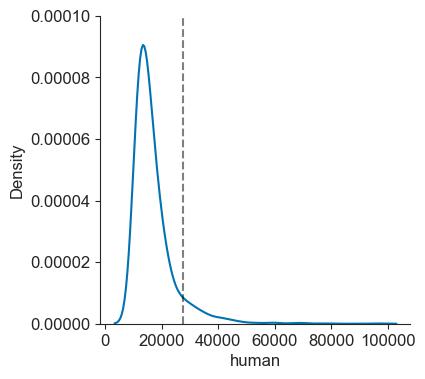

In [35]:
figure, ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(combined[combined.cell_identity != 'canine'].human, bw_method=0.3,  color=colors[0], ax=ax)
sns.despine()
ax.axvline(x=27500,color = 'k',ls = '--', alpha =0.5)
combined = combined[(combined.cell_identity == 'canine') | (combined.cell_identity == 'both') | (combined.human < 27500)]
a = plt.ylim(0,10**-4)
plt.savefig('Figures/doubletRemovalWT.pdf', format='pdf', bbox_inches = "tight")



Use thresholds from NS1 infection to ensure fair comparisons.

In [39]:
nonDoubletList = combined[combined.cell_identity=='human'].cell
justHuman = humanData.loc[humanData.cell.isin(nonDoubletList),]
finalData = combined[combined.cell_identity == 'human'].copy()

#get fractions

typeI = justHuman[justHuman.gene.isin(typeIgenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'type_I_IFN'} )
finalData = finalData.merge(typeI, on='cell', how='left').fillna(0)
finalData['type_I_IFN'] = finalData.type_I_IFN / finalData.human
finalData['type_I_IFN_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.type_I_IFN * row.human , mu=typeIthresh * row.human), axis=1)
finalData['type_I_IFN_positive'] = (multitest.multipletests(finalData.type_I_IFN_pval, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)[0]) & (finalData.type_I_IFN > 0) 

typeIII = justHuman[justHuman.gene.isin(typeIIIgenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'type_III_IFN'} )
finalData = finalData.merge(typeIII, on='cell', how='left').fillna(0)
finalData['type_III_IFN'] = finalData.type_III_IFN / finalData.human
#poisson but calculate vs anticipated UMI
finalData['type_III_IFN_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.type_III_IFN * row.human, mu=typeIIIthresh * row.human), axis=1)
finalData['type_III_IFN_positive'] = (multitest.multipletests(finalData.type_III_IFN_pval, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)[0]) & (finalData.type_III_IFN > 0)

flu = justHuman[justHuman.gene.isin(fluGenes)].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':'influenza'} )
finalData = finalData.merge(flu, on='cell', how='left').fillna(0)
finalData['influenza'] = finalData.influenza / finalData.human
finalData['influenza_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row.influenza * row.human, mu=fluThresh * row.human), axis=1)
finalData['influenza_positive'] = (multitest.multipletests(finalData.influenza_pval, alpha=10**-7.5, method='fdr_bh', is_sorted=False, returnsorted=False)[0])& (finalData.influenza > 0.)



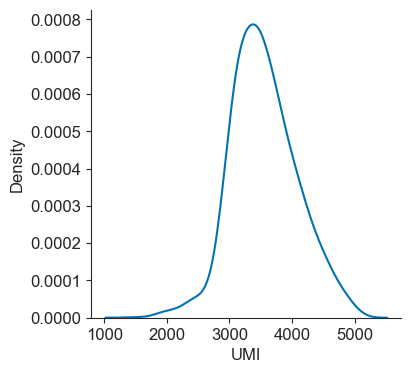

In [41]:
figure, ax = plt.subplots(1,1, figsize=(4,4))

graph = humanData[(humanData.cell.isin(finalData.cell)) & (humanData.UMI > 0)].groupby(['cell']).count()
sns.kdeplot(graph.UMI, bw_method=0.3,  color=colors[0])
sns.despine()
plt.savefig('Figures/geneCountsWT.pdf', format='pdf', bbox_inches = "tight")

In [58]:

for gene in segments:
    geneFrame = justHuman[justHuman.gene == prefix + gene].groupby(['cell']).sum().reset_index().rename(columns = {'UMI':gene} )
    finalData = finalData.merge(geneFrame, on='cell', how='left').fillna(0)
    finalData[gene] = finalData[gene] / finalData.human
    finalData[gene + '_pval'] = finalData.apply(lambda row: 1- poisson.cdf(k=row[gene] * row.human , mu=thresholds[gene] * row.human), axis=1)
    finalData[gene + '_positive'] = (finalData[gene + '_pval'] < 0.01) & (finalData[gene] > 0)


In [59]:
finalData['IFN_positive'] = (finalData.type_III_IFN_positive) | (finalData.type_I_IFN_positive)


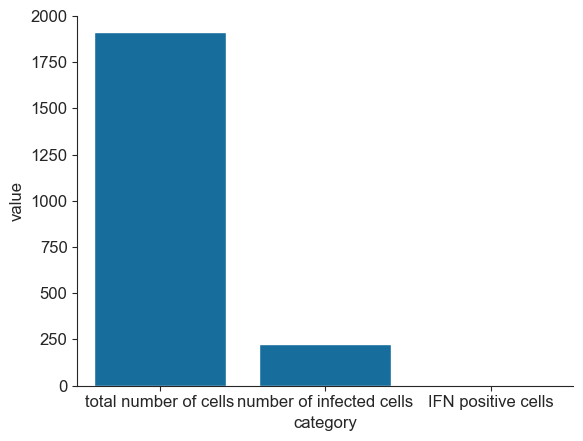

In [60]:
graph = pd.DataFrame({'category':['total number of cells', 'number of infected cells', 'IFN positive cells'], 
                      
                      
                      'value':[len(finalData), len(finalData[finalData.influenza_positive]), len(finalData[finalData.IFN_positive])]})
sns.barplot(data=graph, x='category', y='value', color=colors[0])
sns.despine()
plt.ylim(0,2000)
plt.savefig('Figures/countsWT.pdf', format='pdf', bbox_inches = "tight")

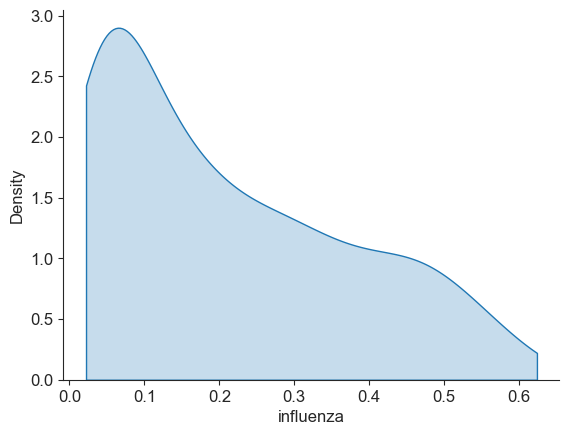

In [61]:
sns.kdeplot(finalData[finalData.influenza_positive].influenza, cut=0, fill=True)
sns.despine()
plt.savefig('Figures/fluBurdenPosCellsWT.pdf', format='pdf', bbox_inches = "tight")

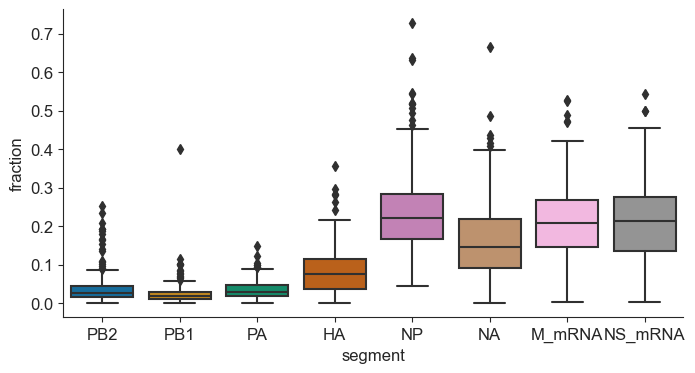

In [62]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
segments = ['PB2','PB1','PA',  'HA','NP','NA','M_mRNA','NS_mRNA']

graph = finalData[finalData.influenza_positive][segments].copy()
graph['sum'] = graph.sum(axis=1)
for segment in segments:
    graph[segment] = graph[segment]/graph['sum']
graph = graph[segments].stack().reset_index().rename(columns = {'level_1':'segment', 0:'fraction'})
sns.boxplot(data = graph, x= 'segment', y ='fraction', order = segments, palette = fluColors,  ax = ax)
sns.despine()
plt.savefig('Figures/fluRatiofluWT.pdf', format='pdf', bbox_inches = "tight")

Segments with significance with an FDR of 0.05
PB2 PB1 PA HA NP NA M_mRNA


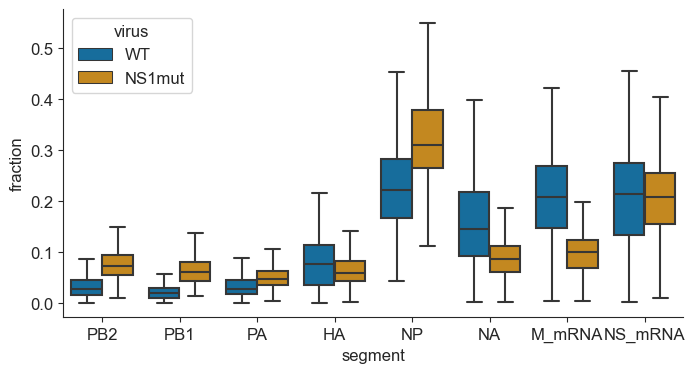

In [63]:
NS1mutRatio['virus'] = 'NS1mut'
graph['virus'] = 'WT'
graph = pd.concat([graph, NS1mutRatio])

fig,ax = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data = graph, x= 'segment', y ='fraction', order = segments, hue='virus', hue_order = ['WT', 'NS1mut'], palette = colors[:2], showfliers = False, ax = ax)
sns.despine()
pvals = []
for segment in segments:
    currFrame = graph[graph.segment == segment]
    statistic, pval = scipy.stats.ttest_ind(currFrame[currFrame.virus == 'WT'].fraction, currFrame[currFrame.virus == 'NS1mut'].fraction, equal_var=False)
    pvals += [pval]
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
print('Segments with significance with an FDR of 0.05')
print(' '.join([segment for index,segment in enumerate(segments) if pvals[index]]))

plt.savefig('Figures/fluRatiofluWTNS1.pdf', format='pdf', bbox_inches = "tight")

Deletions. Lower threshold as rarer so less contamination.

In [64]:
#read in deletions, subset to accepted cells
deletions = pd.read_csv('Results/WTcuratedDeletions.tsv', sep='\t')[['barcode', 'segment', 'fiveprime', 'threeprime', 'count', 'nonDeletionCounts']]
deletions = deletions.rename(columns = {'barcode':'cell'})
deletions = deletions[deletions.cell.isin(finalData.cell)]
#filter to only > 200nt to exclude small deletions
deletions['length'] = deletions.threeprime-deletions.fiveprime
deletions = deletions[deletions.length > 200]
finalData['deletion_observed'] = finalData.cell.isin(deletions.cell)

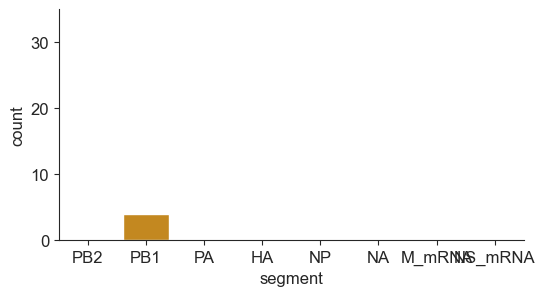

In [65]:
fig,ax = plt.subplots(figsize=(6,3))
graph = deletions.groupby(['segment']).count().reset_index()
sns.barplot(data=graph, x= 'segment', y='count', palette = otherfluColors, order= alternateFlu, ax =ax)
plt.ylim(0,35)
sns.despine()
a = ax.set_xticklabels(segments)
plt.savefig('Figures/numDeletionsObservedWT.pdf', format='pdf', bbox_inches = "tight")